In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt 
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

In [4]:
from walmart_utils.download import download_dataset
from walmart_utils.merge_data import merge_data, dedupe
from walmart_utils.feature_engineering import (
    add_calendar_features, sum_markdown, add_holiday,
    add_memory_feature
)
from walmart_utils.exploratory_analysis import view_data_horizon

## **1. Data Preprocessing**

In [5]:
zip_path = "./walmart-recruiting-store-sales-forecasting.zip"
extract_dir = "./walmart_dataset"

In [6]:
features_df, stores_df, test_df, train_df = download_dataset()

Archivo extraído en: ./walmart_dataset 🫣
Archivo extraído en: ./walmart_dataset 🫣
Archivo extraído en: ./walmart_dataset 🫣
Archivo extraído en: ./walmart_dataset 🫣
Archivo extraído en: ./walmart_dataset 🫣
dataset descargado con éxito :)
dataset formateado :)


In [7]:
print("Train shape: ", train_df.shape)
print("Test shape: ", test_df.shape)
print("Feaures shape: ", features_df.shape)
print("Stores shape: ", stores_df.shape)

Train shape:  (421570, 5)
Test shape:  (115064, 5)
Feaures shape:  (8190, 12)
Stores shape:  (45, 3)


In [8]:
# Create Unique ID to create indices and streamline submissions
train_df['UID'] = (train_df.Store.astype(str)) + '_' +(train_df.Dept.astype(str)) + '_' + (train_df.Date.astype(str))
test_df['UID'] = (test_df.Store.astype(str)) + '_' +(test_df.Dept.astype(str)) + '_' + (test_df.Date.astype(str))

train_df['IsTrain'] = True
test_df['IsTrain'] = False

In [9]:
train_df[(train_df["Store"]==1) & (train_df["Dept"]==1)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,UID,IsTrain
0,1,1,2010-02-05,24924.50,False,1_1_2010-02-05,True
1,1,1,2010-02-12,46039.49,True,1_1_2010-02-12,True
2,1,1,2010-02-19,41595.55,False,1_1_2010-02-19,True
3,1,1,2010-02-26,19403.54,False,1_1_2010-02-26,True
4,1,1,2010-03-05,21827.90,False,1_1_2010-03-05,True
...,...,...,...,...,...,...,...
138,1,1,2012-09-28,18947.81,False,1_1_2012-09-28,True
139,1,1,2012-10-05,21904.47,False,1_1_2012-10-05,True
140,1,1,2012-10-12,22764.01,False,1_1_2012-10-12,True
141,1,1,2012-10-19,24185.27,False,1_1_2012-10-19,True


In [10]:
def features_info():
    display("Información de features: (^◕.◕^) 😼")
    display(features_df.info())
    display("Información de stores: ( •̀ ω •́ )✧ 🫡")
    display(stores_df.info())
    display("Información de train: ヾ(•ω•`)o 🥺")
    display(train_df.info())
    display("Información de test: ╰(*°▽°*)╯ 🫣")
    display(test_df.info())
    return "all!"

In [11]:
features_info()

'Información de features: (^◕.◕^) 😼'

<class 'pandas.core.frame.DataFrame'>
Index: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 775.8 KB


None

'Información de stores: ( •̀ ω •́ )✧ 🫡'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


None

'Información de train: ヾ(•ω•`)o 🥺'

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   UID           421570 non-null  object        
 6   IsTrain       421570 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 20.1+ MB


None

'Información de test: ╰(*°▽°*)╯ 🫣'

<class 'pandas.core.frame.DataFrame'>
Index: 115064 entries, 0 to 115063
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Weekly_Sales  115064 non-null  int64         
 5   UID           115064 non-null  object        
 6   IsTrain       115064 non-null  bool          
dtypes: bool(2), datetime64[ns](1), int64(3), object(1)
memory usage: 5.5+ MB


None

'all!'

Merging stores and features data frames with train and test data with pandas merge.

In [12]:
data = merge_data(train_df, test_df, stores_df, features_df)

In [13]:
data = data.drop(labels="IsHoliday_y", axis=1)
data["IsHoliday"] = data["IsHoliday_x"]
data = data.drop(labels="IsHoliday_x", axis=1)

In [14]:
data.head(3)

,Store,Dept,Date,Weekly_Sales,UID,IsTrain,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,1_1_2010-02-05,True,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
5747,1,1,2010-02-12,46039.49,1_1_2010-02-12,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
6829,1,1,2010-02-19,41595.55,1_1_2010-02-19,True,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


Converting boolean features to 0s and 1s

In [15]:
lb_IsHoliday = LabelBinarizer()
data["IsHoliday"] = lb_IsHoliday.fit_transform(data["IsHoliday"])

In [16]:
data["IsHoliday"].head(5)

0        0
5747     1
6829     0
11698    0
12681    0
Name: IsHoliday, dtype: int32

Checking for missing/nan values

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536634 entries, 0 to 536633
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         536634 non-null  int64         
 1   Dept          536634 non-null  int64         
 2   Date          536634 non-null  datetime64[ns]
 3   Weekly_Sales  536634 non-null  float64       
 4   UID           536634 non-null  object        
 5   IsTrain       536634 non-null  bool          
 6   Type          536634 non-null  object        
 7   Size          536634 non-null  int64         
 8   Temperature   536634 non-null  float64       
 9   Fuel_Price    536634 non-null  float64       
 10  MarkDown1     265596 non-null  float64       
 11  MarkDown2     197685 non-null  float64       
 12  MarkDown3     242326 non-null  float64       
 13  MarkDown4     237143 non-null  float64       
 14  MarkDown5     266496 non-null  float64       
 15  CPI           498472 n

The only features with missing values are MarkDown(1–5) which are anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011 and is not available for all stores all the time. Any missing value is marked with an NA. I have replaced the nan values in these columns with 0.

In [18]:
inputer_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
inputer_zero.fit(data[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]])


SimpleImputer(fill_value=0, strategy='constant')

In [19]:
data[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]] = inputer_zero.transform(data[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]])

The cleaned data looks like this —

In [20]:
data

,Store,Dept,Date,Weekly_Sales,UID,IsTrain,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,1_1_2010-02-05,True,A,151315,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,0
5747,1,1,2010-02-12,46039.49,1_1_2010-02-12,True,A,151315,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,1
6829,1,1,2010-02-19,41595.55,1_1_2010-02-19,True,A,151315,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,0
11698,1,1,2010-02-26,19403.54,1_1_2010-02-26,True,A,151315,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,0
12681,1,1,2010-03-05,21827.90,1_1_2010-03-05,True,A,151315,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523896,45,98,2013-06-28,0.00,45_98_2013-06-28,False,B,118221,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,0
525567,45,98,2013-07-05,0.00,45_98_2013-07-05,False,B,118221,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,0
527978,45,98,2013-07-12,0.00,45_98_2013-07-12,False,B,118221,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,0
532235,45,98,2013-07-19,0.00,45_98_2013-07-19,False,B,118221,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,0


## **Feature Engineering**

From the Date column, I have extracted DayOfMonth, Month, Year, DayOfWeek, WeekOfYear, and Quarter and dropped the Date column

In [21]:
data = add_calendar_features(data)

In [22]:
data.head(5)

,Store,Dept,Date,Weekly_Sales,UID,IsTrain,Type,Size,Temperature,Fuel_Price,...,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,month,day_of_month,week_of_year,quarter,year
0,1,1,2010-02-05,24924.50,1_1_2010-02-05,True,A,151315,42.31,2.572,...,0.0,0.0,211.096358,8.106,0,2,28,5,1,2010
5747,1,1,2010-02-12,46039.49,1_1_2010-02-12,True,A,151315,38.51,2.548,...,0.0,0.0,211.242170,8.106,1,2,28,6,1,2010
6829,1,1,2010-02-19,41595.55,1_1_2010-02-19,True,A,151315,39.93,2.514,...,0.0,0.0,211.289143,8.106,0,2,28,7,1,2010
11698,1,1,2010-02-26,19403.54,1_1_2010-02-26,True,A,151315,46.63,2.561,...,0.0,0.0,211.319643,8.106,0,2,28,8,1,2010
12681,1,1,2010-03-05,21827.90,1_1_2010-03-05,True,A,151315,46.50,2.625,...,0.0,0.0,211.350143,8.106,0,3,31,9,1,2010


Created a new column called MarkDown which is the sum of all MarkDown(1–5) columns after which those 5 columns were dropped

In [23]:
data = sum_markdown(data=data, colums=["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4","MarkDown5"])

In [24]:
data["MarkDown"].sample(5)

447472    67107.66
330167    13079.21
227097        0.00
268504        0.00
86677         0.00
Name: MarkDown, dtype: float64

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

In [25]:
super_bowl = ["12-02-10", "11-02-11", "10-02-12", "08-02-13"]
labor_day =  ["10-09-10", "09-09-11", "07-09-12", "06-09-13"]
thanks_giving = ["26-11-10", "25-11-11", "23-11-12", "29-11-13"]
christmas = ["31-12-10", "30-12-11", "28-12-12", "27-12-13"]
holiday_list  = super_bowl + labor_day + thanks_giving + christmas
holiday_list[:5]

['12-02-10', '11-02-11', '10-02-12', '08-02-13', '10-09-10']

In [26]:
data = add_holiday(data, holiday_list )

In [27]:
data.describe()

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,month,day_of_month,week_of_year,quarter,year,MarkDown
count,536634.000000,536634.000000,536634,536634.000000,536634.00000,536634.000000,536634.000000,498472.000000,498472.000000,536634.000000,536634.000000,536634.000000,536634.0,536634.000000,536634.000000,536634.000000
mean,22.208621,44.277301,2011-11-01 13:33:31.458088704,12554.588392,136678.55096,58.771762,3.408310,172.090481,7.791888,0.071909,6.295203,30.422478,25.231581,2.429537,2011.354241,9450.260975
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,34875.00000,-7.290000,2.472000,126.064000,3.684000,0.000000,1.000000,28.000000,1.0,1.000000,2010.000000,-1692.480000
25%,11.000000,18.000000,2010-12-17 00:00:00,49.852500,93638.00000,45.250000,3.041000,132.521867,6.623000,0.000000,3.000000,30.000000,13.0,1.000000,2010.000000,0.000000
50%,22.000000,37.000000,2011-11-04 00:00:00,4118.755000,140167.00000,60.060000,3.523000,182.442420,7.795000,0.000000,6.000000,31.000000,24.0,2.000000,2011.000000,0.000000
75%,33.000000,74.000000,2012-09-14 00:00:00,15497.417500,202505.00000,73.230000,3.744000,213.748126,8.549000,0.000000,9.000000,31.000000,37.0,3.000000,2012.000000,12868.220000
max,45.000000,99.000000,2013-07-26 00:00:00,693099.360000,219622.00000,101.950000,4.468000,228.976456,14.313000,1.000000,12.000000,31.000000,52.0,4.000000,2013.000000,783529.450000
std,12.790580,30.527358,NaN,21171.249456,61007.71180,18.678716,0.430861,39.542149,1.865076,0.258338,3.333808,0.827435,14.554119,1.092347,1.040218,19696.611637


In [28]:
data = add_memory_feature(data_df=data, target= "Weekly_Sales")

Adding memory variable 😸: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


In [29]:
data

,Store,Dept,Date,Weekly_Sales,UID,IsTrain,Type,Size,Temperature,Fuel_Price,...,l_3_w_4_median_Weekly_Sales,l_3_w_4_std_Weekly_Sales,l_3_w_4_max_Weekly_Sales,l_3_w_4_min_Weekly_Sales,l_3_w_5_sum_Weekly_Sales,l_3_w_5_mean_Weekly_Sales,l_3_w_5_median_Weekly_Sales,l_3_w_5_std_Weekly_Sales,l_3_w_5_max_Weekly_Sales,l_3_w_5_min_Weekly_Sales
0,1,1,2010-02-05,24924.50,1_1_2010-02-05,True,A,151315,42.31,2.572,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5747,1,1,2010-02-12,46039.49,1_1_2010-02-12,True,A,151315,38.51,2.548,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6829,1,1,2010-02-19,41595.55,1_1_2010-02-19,True,A,151315,39.93,2.514,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11698,1,1,2010-02-26,19403.54,1_1_2010-02-26,True,A,151315,46.63,2.561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12681,1,1,2010-03-05,21827.90,1_1_2010-03-05,True,A,151315,46.50,2.625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523896,45,98,2013-06-28,0.00,45_98_2013-06-28,False,B,118221,76.05,3.639,...,770.690,70.249079,874.64,713.50,4023.12,804.624,795.94,78.582297,893.60,713.50
525567,45,98,2013-07-05,0.00,45_98_2013-07-05,False,B,118221,77.50,3.614,...,826.145,72.655671,874.64,713.50,3985.87,797.174,795.94,69.249635,874.64,713.50
527978,45,98,2013-07-12,0.00,45_98_2013-07-12,False,B,118221,79.37,3.614,...,784.925,120.107491,874.64,622.62,3863.05,772.610,795.94,104.830565,874.64,622.62
532235,45,98,2013-07-19,0.00,45_98_2013-07-19,False,B,118221,82.84,3.737,...,702.010,98.290848,856.35,622.62,3757.63,751.526,713.50,109.464142,874.64,622.62


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536634 entries, 0 to 536633
Data columns (total 95 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Store                        536634 non-null  int64         
 1   Dept                         536634 non-null  int64         
 2   Date                         536634 non-null  datetime64[ns]
 3   Weekly_Sales                 536634 non-null  float64       
 4   UID                          536634 non-null  object        
 5   IsTrain                      536634 non-null  bool          
 6   Type                         536634 non-null  object        
 7   Size                         536634 non-null  int64         
 8   Temperature                  536634 non-null  float64       
 9   Fuel_Price                   536634 non-null  float64       
 10  CPI                          498472 non-null  float64       
 11  Unemployment                 49

In [37]:
view_data_horizon(data, target="l_3_w_5_min_Weekly_Sales")

In [42]:
view_data_horizon(data, target="l_0_w_3_sum_Weekly_Sales")

In [43]:
view_data_horizon(data, target="Weekly_Sales")

In [39]:
data = data[data["Date"] >= "2011-03-25"]

In [40]:
data["Date"].min()

Timestamp('2011-03-25 00:00:00')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363648 entries, 173464 to 536633
Data columns (total 95 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Store                        363648 non-null  int64         
 1   Dept                         363648 non-null  int64         
 2   Date                         363648 non-null  datetime64[ns]
 3   Weekly_Sales                 363648 non-null  float64       
 4   UID                          363648 non-null  object        
 5   IsTrain                      363648 non-null  bool          
 6   Type                         363648 non-null  object        
 7   Size                         363648 non-null  int64         
 8   Temperature                  363648 non-null  float64       
 9   Fuel_Price                   363648 non-null  float64       
 10  CPI                          325486 non-null  float64       
 11  Unemployment              

In [47]:
data[(data["Store"]==12) & (data["Dept"]==1)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 123 entries, 173814 to 534505
Data columns (total 95 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Store                        123 non-null    int64         
 1   Dept                         123 non-null    int64         
 2   Date                         123 non-null    datetime64[ns]
 3   Weekly_Sales                 123 non-null    float64       
 4   UID                          123 non-null    object        
 5   IsTrain                      123 non-null    bool          
 6   Type                         123 non-null    object        
 7   Size                         123 non-null    int64         
 8   Temperature                  123 non-null    float64       
 9   Fuel_Price                   123 non-null    float64       
 10  CPI                          110 non-null    float64       
 11  Unemployment                 110 non-null 

## **Exploratory data analysis**

Mapa de calor de la matriz de correlación

In [28]:
numeric_columns = [
    'Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature',
    'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'month',
    'day_of_month', 'week_of_year', 'quarter', 'year', 'MarkDown'
]
data[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 536634 entries, 0 to 536633
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         536634 non-null  int64  
 1   Dept          536634 non-null  int64  
 2   Weekly_Sales  536634 non-null  float64
 3   Size          536634 non-null  int64  
 4   Temperature   536634 non-null  float64
 5   Fuel_Price    536634 non-null  float64
 6   CPI           498472 non-null  float64
 7   Unemployment  498472 non-null  float64
 8   IsHoliday     536634 non-null  int32  
 9   month         536634 non-null  int32  
 10  day_of_month  536634 non-null  int32  
 11  week_of_year  536634 non-null  UInt32 
 12  quarter       536634 non-null  int32  
 13  year          536634 non-null  int32  
 14  MarkDown      536634 non-null  float64
dtypes: UInt32(1), float64(6), int32(5), int64(3)
memory usage: 53.7 MB


In [29]:
print("Fecha de inicio de train", train_df["Date"].min())
print("Fecha de fin de train",train_df["Date"].max())

print("Fecha de inicio de test", test_df["Date"].min())
print("Fecha de fin de test",test_df["Date"].max())

Fecha de inicio de train 2010-02-05 00:00:00
Fecha de fin de train 2012-10-26 00:00:00
Fecha de inicio de test 2012-11-02 00:00:00
Fecha de fin de test 2013-07-26 00:00:00


In [30]:
missing_data = data[data['CPI'].isna() | data['Unemployment'].isna()]

In [31]:
view_data_horizon(data, target="CPI")

In [32]:
view_data_horizon(data, target="Unemployment")

In [37]:
view_data_horizon(data, target="Temperature")

In [38]:
view_data_horizon(data, target="Weekly_Sales")

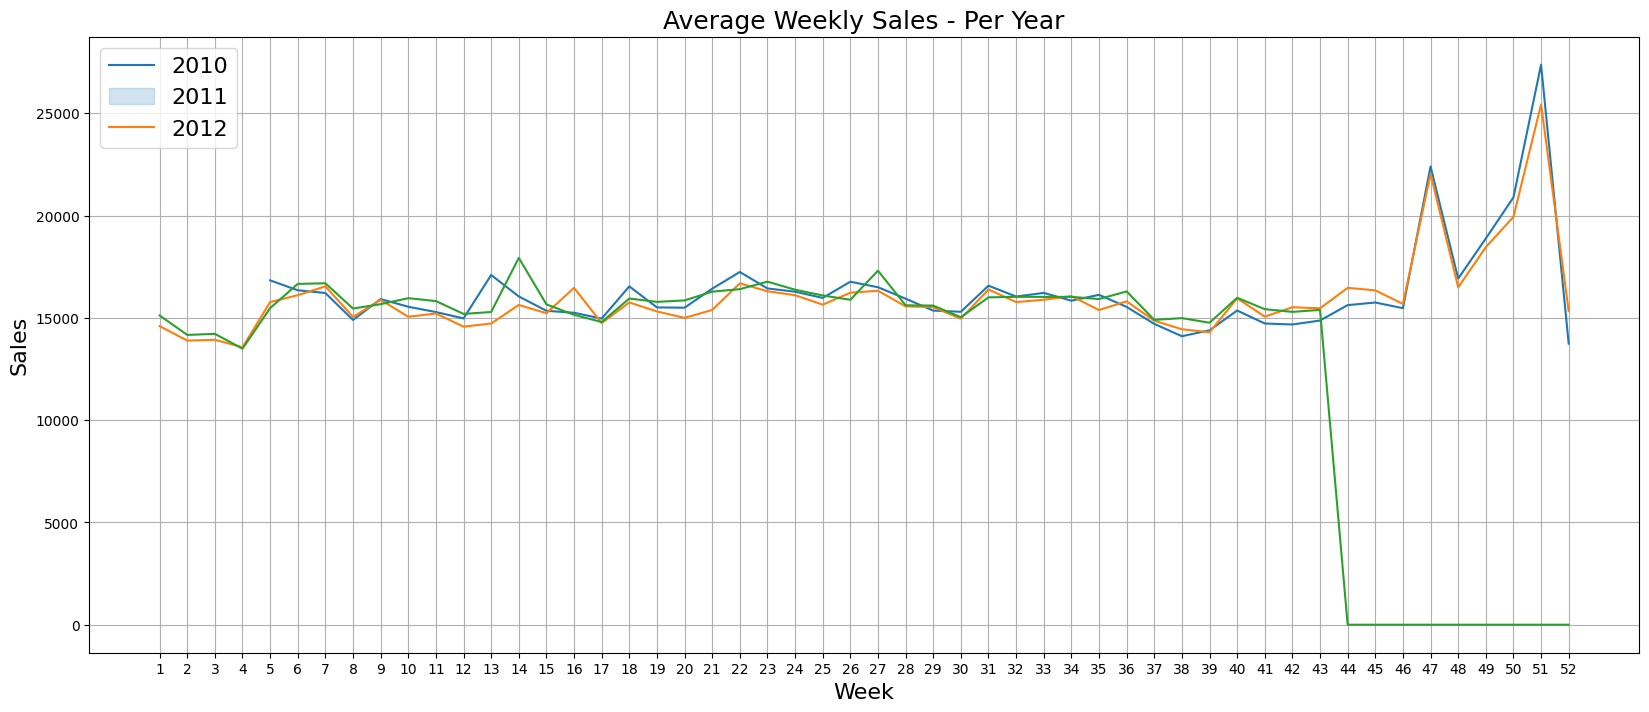

In [39]:
weekly_sales_2010 = data[data.year==2010]['Weekly_Sales'].groupby(data['week_of_year']).mean()
weekly_sales_2011 = data[data.year==2011]['Weekly_Sales'].groupby(data['week_of_year']).mean()
weekly_sales_2012 = data[data.year==2012]['Weekly_Sales'].groupby(data['week_of_year']).mean()

plt.figure(figsize=(20,8))

sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)

plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()


In [40]:
corr_df = data[numeric_columns].corr(method="pearson")

fig = px.imshow(
    corr_df.values,
    x=numeric_columns,
    y=numeric_columns,
)
fig.update_xaxes(side="top")
fig.show()

## **3. Preparing to Train Models**

Splitting into train and validation sets (75–25 split)

In [37]:
print("Fecha de inicio de train", train_df["Date"].min())
print("Fecha de fin de train",train_df["Date"].max())


Fecha de inicio de train 2010-02-05 00:00:00
Fecha de fin de train 2012-10-26 00:00:00


In [38]:
print("Fecha de inicio de test", test_df["Date"].min())
print("Fecha de fin de test",test_df["Date"].max())

Fecha de inicio de test 2012-11-02 00:00:00
Fecha de fin de test 2013-07-26 00:00:00


In [39]:
# train_data = data[ data["Date"] <=  "2012-10-26"]
# test_df = data[ data["Date"] >  "2012-10-26"]


In [40]:
# train_size = int(.75 * len(train_data))
# train_df, val_df = train_data[:train_size], train_data[train_size:]

Identifying numeric and categorical columns

In [41]:
# train_df.info()

In [42]:
# def num_cat_cols(data):
#     numeric_cols = data.select_dtypes(include=['int64', 'int32','UInt32', 'float64']).columns.tolist()
#     categorical_cols = data.select_dtypes('object').columns.tolist()
#     return numeric_cols, categorical_cols

In [43]:
# numeric_cols, categorical_cols  = num_cat_cols(train_df)
# display(numeric_cols)
# display(categorical_cols)

In [44]:
input_cols = numeric_cols + categorical_cols
target_col = ['Weekly_Sales']

NameError: name 'numeric_cols' is not defined

Imputation, Scaling, and Encoding